Accuracy: 43.33%


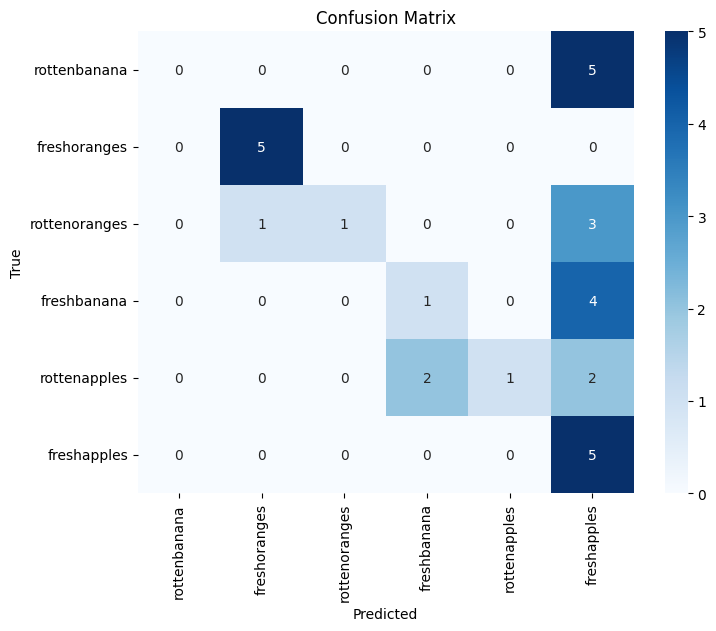

In [1]:
import os
import cv2
import numpy as np
import random
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to compute histogram of an image
def compute_histogram(image, bins=(8, 8, 8)):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # Convert image to HSV space
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])  # Compute the 3D histogram
    hist = cv2.normalize(hist, hist).flatten()  # Normalize and flatten histogram
    return hist

# Function to compute GLCM manually
def compute_glcm(image, distance=1, angle=0):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.int32)
    rows, cols = gray.shape

    # Initialize GLCM
    glcm = np.zeros((256, 256), dtype=np.float32)

    # Compute GLCM based on distance and angle
    if angle == 0:  # Horizontal
        for i in range(rows):
            for j in range(cols - distance):
                glcm[gray[i, j], gray[i, j + distance]] += 1
    elif angle == 90:  # Vertical
        for i in range(rows - distance):
            for j in range(cols):
                glcm[gray[i, j], gray[i + distance, j]] += 1
    elif angle == 45:  # Diagonal (top-right to bottom-left)
        for i in range(rows - distance):
            for j in range(cols - distance):
                glcm[gray[i, j], gray[i + distance, j + distance]] += 1
    elif angle == 135:  # Diagonal (top-left to bottom-right)
        for i in range(distance, rows):
            for j in range(cols - distance):
                glcm[gray[i, j], gray[i - distance, j + distance]] += 1

    # Normalize GLCM
    glcm /= np.sum(glcm)
    return glcm

# Function to compute texture features from GLCM
def compute_texture_features(image):
    glcm = compute_glcm(image, distance=1, angle=0)  # Compute GLCM (horizontal)
    
    # Initialize features
    contrast = 0
    dissimilarity = 0
    homogeneity = 0
    energy = 0
    correlation = 0

    # Compute mean and standard deviation
    mean_i = np.sum(np.arange(256) * np.sum(glcm, axis=1))
    mean_j = np.sum(np.arange(256) * np.sum(glcm, axis=0))
    std_i = np.sqrt(np.sum((np.arange(256) - mean_i)**2 * np.sum(glcm, axis=1)))
    std_j = np.sqrt(np.sum((np.arange(256) - mean_j)**2 * np.sum(glcm, axis=0)))

    # Compute features
    for i in range(256):
        for j in range(256):
            contrast += glcm[i, j] * (i - j)**2
            dissimilarity += glcm[i, j] * abs(i - j)
            homogeneity += glcm[i, j] / (1 + (i - j)**2)
            energy += glcm[i, j]**2
            if std_i > 0 and std_j > 0:
                correlation += glcm[i, j] * (i - mean_i) * (j - mean_j) / (std_i * std_j)

    return np.array([contrast, dissimilarity, homogeneity, energy, correlation])

# Function to compute Pearson correlation between two feature sets
def pearson_correlation(features1, features2):
    return np.corrcoef(features1, features2)[0, 1]

# Directory paths for train and test images
train_dir = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train'
test_dir = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test'

# Randomly select n samples per class for training and testing
n_samples = 5 # Number of samples per class to use

# Prepare data to store features of each class
class_histograms = {}
class_texture_features = {}
class_names = []

# Loop through the train directory and compute features for n randomly selected images per class
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_histograms[class_name] = []
        class_texture_features[class_name] = []
        class_names.append(class_name)
        
        # Get a list of all images in this class
        images_in_class = os.listdir(class_path)
        
        # Randomly select n samples from the class
        selected_images = random.sample(images_in_class, min(n_samples, len(images_in_class)))
        
        for image_name in selected_images:
            image_path = os.path.join(class_path, image_name)
            image = cv2.imread(image_path)
            if image is None:
                continue  # Skip if image loading fails
            hist = compute_histogram(image)
            texture_features = compute_texture_features(image)
            
            class_histograms[class_name].append(hist)
            class_texture_features[class_name].append(texture_features)

# Loop through test images and predict their class
y_true = []  # Ground truth
y_pred = []  # Predicted labels

for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        
        # Get a list of all images in this class
        images_in_class = os.listdir(class_path)
        
        # Randomly select n test samples from the class
        selected_images = random.sample(images_in_class, min(n_samples, len(images_in_class)))
        
        for image_name in selected_images:
            image_path = os.path.join(class_path, image_name)
            image = cv2.imread(image_path)
            if image is None:
                continue  # Skip if image loading fails
            
            # Compute features for test image
            test_hist = compute_histogram(image)
            test_texture = compute_texture_features(image)
            
            # Compute correlation for each class
            correlations = {}
            for class_name_train, histograms in class_histograms.items():
                class_correlations = [pearson_correlation(test_hist, hist) for hist in histograms]
                correlations[class_name_train] = np.mean(class_correlations)  # Average correlation for this class

            # Compute texture correlation for each class
            texture_correlations = {}
            for class_name_train, texture_feats in class_texture_features.items():
                class_texture_correlations = [pearson_correlation(test_texture, tex) for tex in texture_feats]
                texture_correlations[class_name_train] = np.mean(class_texture_correlations)
            
            # Combine color and texture correlations
            final_correlations = {class_name_train: correlations[class_name_train] + texture_correlations[class_name_train]
                                  for class_name_train in class_names}

            # Predict the class with the highest combined correlation
            predicted_class = max(final_correlations, key=final_correlations.get)
            
            # Append true and predicted labels
            y_true.append(class_name)
            y_pred.append(predicted_class)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=class_names)

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [2]:
from sklearn.metrics import classification_report

# Print classification report
report = classification_report(y_true, y_pred, labels=class_names, digits=2)
print("Classification Report:")
print(report)


Classification Report:
               precision    recall  f1-score   support

 rottenbanana       0.00      0.00      0.00         5
 freshoranges       0.83      1.00      0.91         5
rottenoranges       1.00      0.20      0.33         5
  freshbanana       0.33      0.20      0.25         5
 rottenapples       1.00      0.20      0.33         5
  freshapples       0.26      1.00      0.42         5

     accuracy                           0.43        30
    macro avg       0.57      0.43      0.37        30
 weighted avg       0.57      0.43      0.37        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
